In [1]:
# Import Libraries & Load Demographic Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots render inline if running in Jupyter
%matplotlib inline

# Display all columns when inspecting DataFrames
pd.set_option("display.max_columns", None)


In [2]:
# Load and combine all demographic CSV files
demo_paths = [
    "../DATA/api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv",
    "../DATA/api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv",
    "../DATA/api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv",
    "../DATA/api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv",
    "../DATA/api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv",
]

Demo_df = pd.concat([pd.read_csv(p) for p in demo_paths], ignore_index=True)

Demo_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [3]:
# Data Cleaning & Preprocessing for Demographic Updates
# Convert date to datetime
Demo_df["date"] = pd.to_datetime(Demo_df["date"], format="%d-%m-%Y")

# Standardize state and district names
Demo_df["state"] = Demo_df["state"].str.strip().str.title()
Demo_df["district"] = Demo_df["district"].str.strip().str.title()

# Handle missing values (treat missing counts as 0)
Demo_df[["demo_age_5_17", "demo_age_17_"]] = Demo_df[["demo_age_5_17", "demo_age_17_"]].fillna(0)

# Ensure numeric columns
Demo_df[["demo_age_5_17", "demo_age_17_"]] = Demo_df[["demo_age_5_17", "demo_age_17_"]].astype(int)

# Create total demographic update column
Demo_df["total_demo_updates"] = Demo_df[["demo_age_5_17", "demo_age_17_"]].sum(axis=1)

Demo_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_,total_demo_updates
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,578
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,397
2,2025-03-01,Gujarat,Rajkot,360006,65,765,830
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,338
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,830


In [4]:
# Feature Engineering & Aggregations for Demographic Updates

# Extract time features
Demo_df["year"] = Demo_df["date"].dt.year
Demo_df["month"] = Demo_df["date"].dt.month

# State-level aggregation
state_demo = Demo_df.groupby("state")["total_demo_updates"].sum().reset_index()

# Time-series aggregation (monthly)
monthly_demo = (
    Demo_df.groupby(["year", "month"])["total_demo_updates"]
    .sum()
    .reset_index()
)

# District-level aggregation (optional, for drilling down)
district_demo = (
    Demo_df.groupby(["state", "district"])["total_demo_updates"]
    .sum()
    .reset_index()
)

state_demo.head()

,state,total_demo_updates
0,100000,2
1,Andaman & Nicobar Islands,1059
2,Andaman And Nicobar Islands,6187
3,Andhra Pradesh,2295582
4,Arunachal Pradesh,36443


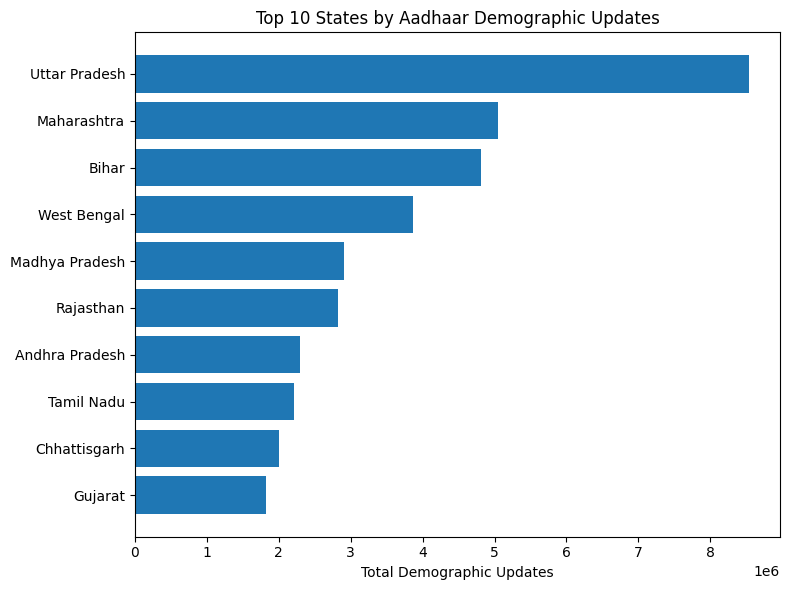

In [5]:
# State-wise Demographic Update Intensity (Top 10 States)

state_demo_sorted = state_demo.sort_values("total_demo_updates", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(state_demo_sorted["state"].head(10), state_demo_sorted["total_demo_updates"].head(10))
plt.xlabel("Total Demographic Updates")
plt.title("Top 10 States by Aadhaar Demographic Updates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../images/demo_top_states.png", dpi=150, bbox_inches="tight")
plt.show()

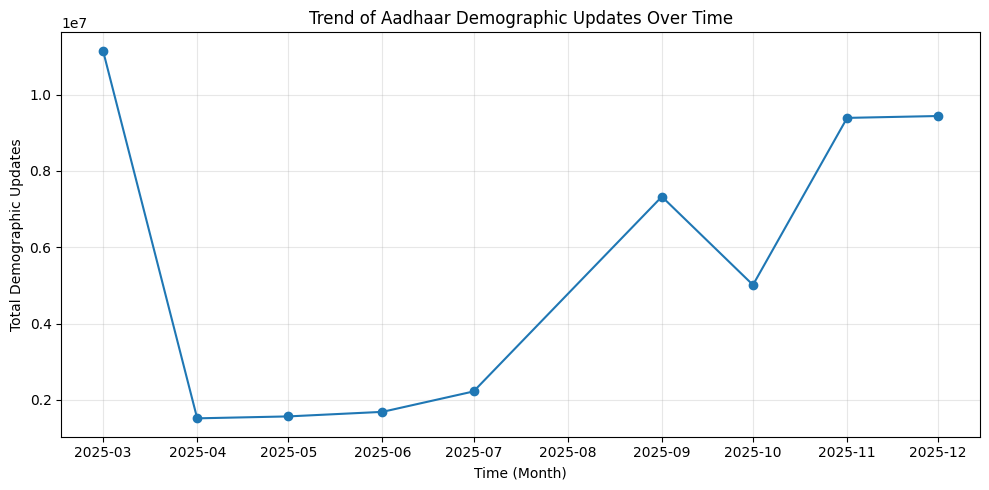

In [6]:
# Time Trend of Demographic Updates (Monthly Aggregation)

monthly_demo["date"] = pd.to_datetime(
    monthly_demo["year"].astype(str) + "-" + monthly_demo["month"].astype(str) + "-01"
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_demo["date"], monthly_demo["total_demo_updates"], marker="o")
plt.xlabel("Time (Month)")
plt.ylabel("Total Demographic Updates")
plt.title("Trend of Aadhaar Demographic Updates Over Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../images/demo_trend.png", dpi=150, bbox_inches="tight")
plt.show()

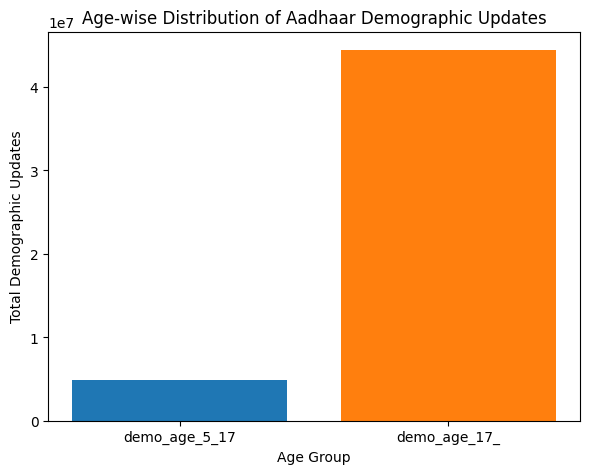

In [7]:
# Age-group Distribution of Demographic Updates (All India)

age_demo_total = Demo_df[["demo_age_5_17", "demo_age_17_"]].sum()

plt.figure(figsize=(6, 5))
plt.bar(age_demo_total.index, age_demo_total.values, color=["#1f77b4", "#ff7f0e"])
plt.xlabel("Age Group")
plt.ylabel("Total Demographic Updates")
plt.title("Age-wise Distribution of Aadhaar Demographic Updates")
plt.tight_layout()
plt.savefig("../images/demo_age_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

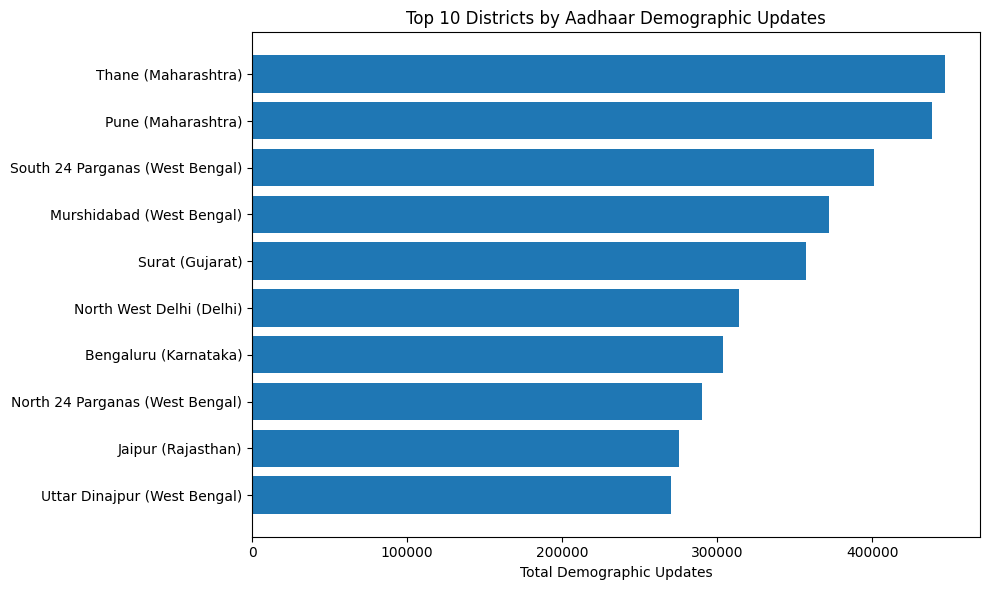

In [8]:
# District-level Hotspots for Demographic Updates (Top 10 Districts)

district_demo_sorted = district_demo.sort_values("total_demo_updates", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    district_demo_sorted["district"] + " (" + district_demo_sorted["state"] + ")",
    district_demo_sorted["total_demo_updates"],
)
plt.xlabel("Total Demographic Updates")
plt.title("Top 10 Districts by Aadhaar Demographic Updates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../images/demo_top_districts.png", dpi=150, bbox_inches="tight")
plt.show()

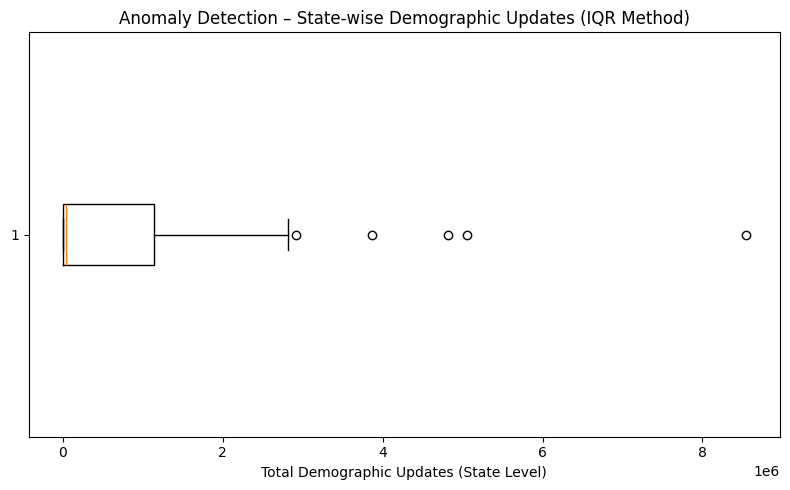

,state,total_demo_updates
50,Uttar Pradesh,8542328
32,Maharashtra,5054602
7,Bihar,4814350
55,West Bengal,3872318
31,Madhya Pradesh,2912938


In [9]:
# Anomaly Detection (State-wise Demographic Updates using IQR)

Q1_demo = state_demo["total_demo_updates"].quantile(0.25)
Q3_demo = state_demo["total_demo_updates"].quantile(0.75)
IQR_demo = Q3_demo - Q1_demo

anomalous_demo_states = state_demo[
    (state_demo["total_demo_updates"] < (Q1_demo - 1.5 * IQR_demo))
    | (state_demo["total_demo_updates"] > (Q3_demo + 1.5 * IQR_demo))
]

plt.figure(figsize=(8, 5))
plt.boxplot(state_demo["total_demo_updates"], vert=False)
plt.xlabel("Total Demographic Updates (State Level)")
plt.title("Anomaly Detection – State-wise Demographic Updates (IQR Method)")
plt.tight_layout()
plt.savefig("../images/demo_anomalies.png", dpi=150, bbox_inches="tight")
plt.show()

anomalous_demo_states.sort_values("total_demo_updates", ascending=False)

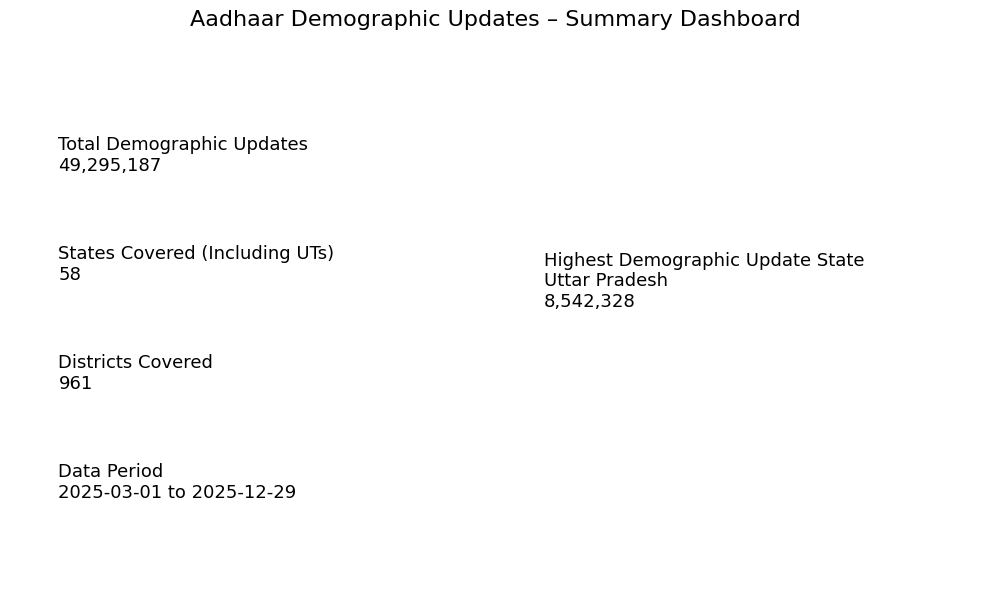

In [10]:
# Summary Dashboard – Aadhaar Demographic Updates

total_demo_updates_overall = Demo_df["total_demo_updates"].sum()
unique_states_demo = Demo_df["state"].nunique()
unique_districts_demo = Demo_df["district"].nunique()
date_range_demo = f"{Demo_df['date'].min().date()} to {Demo_df['date'].max().date()}"

# Top state by demographic updates
top_demo_state = state_demo.sort_values("total_demo_updates", ascending=False).iloc[0]

plt.figure(figsize=(10, 6))
plt.title("Aadhaar Demographic Updates – Summary Dashboard", fontsize=16)

plt.text(0.05, 0.75, f"Total Demographic Updates\n{total_demo_updates_overall:,}", fontsize=13)
plt.text(0.05, 0.55, f"States Covered (Including UTs)\n{unique_states_demo}", fontsize=13)
plt.text(0.05, 0.35, f"Districts Covered\n{unique_districts_demo}", fontsize=13)
plt.text(0.05, 0.15, f"Data Period\n{date_range_demo}", fontsize=13)

plt.text(
    0.55,
    0.5,
    f"Highest Demographic Update State\n{top_demo_state['state']}\n{top_demo_state['total_demo_updates']:,}",
    fontsize=13,
)

plt.axis("off")
plt.tight_layout()
plt.savefig("../images/demo_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()